In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import eli5
from eli5.sklearn import PermutationImportance
import re
import datetime
import itertools

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
def data_cleaning(df, 
                  tourneys_to_include = ['Grand Slams', 'Masters', '250 or 500', 'Tour Finals', 'Davis Cup'], 
                  start_year=2000 ):
    
    #Renaming columns
    new_cols = [
    'Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'draw_size',
       'tourney_level', 'match_num', 'winner_id', 'winner_seed',
       'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'winner_rank', 'winner_rank_points', 'loser_id',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points', 'score',
       'best_of', 'round', 'minutes', 'winner_ace', 'winner_df', 'winner_svpt', 'winner_1stIn',
       'winner_1stWon', 'winner_2ndWon', 'winner_SvGms', 'winner_bpSaved', 'winner_bpFaced', 'loser_ace',
       'loser_df', 'loser_svpt', 'loser_1stIn', 'loser_1stWon', 'loser_2ndWon', 'loser_SvGms',
       'loser_bpSaved', 'loser_bpFaced', 'W1', 'W2', 'W3', 'W4', 'W5', 'L1', 'L2',
       'L3', 'L4', 'L5', 'retirement', 'WTB1', 'LTB1', 'WTB2', 'LTB2', 'WTB3',
       'LTB3', 'WTB4', 'LTB4', 'WTB5', 'LTB5', 'tourney_start_date', 'year',
       'match_id', 'winner_old_elo', 'loser_old_elo'
    ]
    
    df.columns = new_cols
    
    #You can change what matches to include. I've chosen to exclude Futures matches and the Challenger tour
    # tourney_levels = 'Grand Slams', '250 or 500', 'Davis Cup', 'Masters', 'Challenger', 'Tour Finals', 'Futures'
    df = df[(df['tourney_level'].isin(tourneys_to_include)) &\
            (df['year'] >= start_year) & (df['surface'] == 'Hard')&\
            (~df['round'].isin(['Q1', 'Q2', 'Q3', 'Q4']))
           ]

    #Converting dates to datetime
    df.loc[:,'tourney_start_date'] = pd.to_datetime(df['tourney_start_date'])
    df.loc[:,'year'] = pd.to_datetime(df['year'])
    
    #Factorizing round
    df.loc[:,'round'] = pd.factorize(df['round'])[0]
    
    #Parsing scores
    scores = df.loc[:,'score'].str.split(' ')
    scores = scores.fillna(0)     
    loser_total_games = []
    winner_total_games = []
    
    for index, value in scores.items():
        loser_game_score = 0
        winner_game_score = 0
        try:
            if value == 0 or value == ['W/O']:            
                loser_total_games.append(loser_game_score)
                winner_total_games.append(winner_game_score)

            else:
                loser_game_score = 0
                winner_game_score = 0

                for set_ in value:                
                    try:
                        text = re.match(r"(\d)\-(\d)",set_ )
                        loser_game_score += int(text.group(2))
                        winner_game_score += int(text.group(1))
                    except:
                        pass
                loser_total_games.append(loser_game_score)
                winner_total_games.append(winner_game_score)
        except:
            print(index, value)

    df.loc[:,'winner_total_games'] = winner_total_games
    df.loc[:,'loser_total_games'] = loser_total_games
    df.loc[:,'total_games'] = df['winner_total_games'] + df['loser_total_games']
    df.loc[:,'loser_RtGms'] = df['winner_SvGms']
    df.loc[:,'winner_RtGms'] = df['loser_SvGms']
    df.loc[:,'loser_bp'] = df['winner_bpFaced']
    df.loc[:,'winner_bp'] = df['loser_bpFaced']


    df.loc[:,'loser_bpWon'] = df['winner_bpFaced'] - df['winner_bpSaved'] 
    df.loc[:,'winner_bpWon'] = df['loser_bpFaced'] - df['loser_bpSaved'] 
    
    #Imputing returns data so we can construct features
    df.loc[:,'winner_2ndIn'] = df['winner_svpt'] - df['winner_1stIn'] - df['winner_df']
    df.loc[:,'loser_2ndIn'] = df['loser_svpt'] - df['loser_1stIn'] - df['loser_df']
    df.loc[:,'loser_rtpt'] = df['winner_svpt']
    df.loc[:,'winner_rtpt'] = df['loser_svpt']
    df.loc[:,'winner_rtptWon'] = df['loser_svpt'] -  df['loser_1stWon'] - df['loser_2ndWon']
    df.loc[:,'loser_rtptWon'] = df['winner_svpt'] -  df['winner_1stWon'] - df['winner_2ndWon']
    df.loc[:,'winner_svptWon'] = df['winner_1stWon'] + df['winner_2ndWon']
    df.loc[:,'loser_svptWon'] = df['loser_1stWon'] + df['loser_2ndWon']
    df.loc[:,'winner_total_points'] = df['winner_svptWon'] + df['winner_rtptWon']
    df.loc[:,'loser_total_points'] = df['loser_svptWon'] + df['loser_rtptWon']
    df.loc[:,'total_points'] = df['winner_total_points'] + df['loser_total_points']
    
    #Dropping columns
    cols_to_drop =[
        'draw_size',
        'winner_seed',
        'winner_entry',
        'loser_seed',
        'loser_entry',
        'score',
        'W1', 'W2', 'W3', 'W4', 'W5', 'L1', 'L2',
        'L3', 'L4', 'L5', 'WTB1', 'LTB1', 'WTB2', 'LTB2', 'WTB3',
        'LTB3', 'WTB4', 'LTB4', 'WTB5', 'LTB5'
        ]
    
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    #Filling nans values
    df.loc[:,'loser_rank'] = df['loser_rank'].fillna(500)
    df.loc[:,'winner_rank'] = df['winner_rank'].fillna(500)
    df = df.fillna(df.mean())
    
    return(df)

def convert_long(df):
    
    #Separating features into winner and loser so we can create rolling averages for each major tournament
    winner_cols = [col for col in df.columns if col.startswith('w')]
    loser_cols = [col for col in df.columns if col.startswith('l')]
    common_cols = [
        'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'match_num','best_of', 'round',
       'minutes','retirement', 'tourney_start_date', 'year', 'match_id',
        'total_points', 'total_games'
    ]
    
    #Will also add opponent's rank
    df_winner = df[winner_cols + common_cols + ['loser_rank']]
    df_loser = df[loser_cols + common_cols + ['winner_rank']]
    
    df_winner['won'] = 1
    df_loser['won'] = 0
    
    #Renaming columns
    df_winner.columns = [col.replace('winner','player').replace('loser', 'opponent') for col in df_winner.columns]
    df_loser.columns = df_winner.columns
    
    df_long = df_winner.append(df_loser, ignore_index=True)
    
    return(df_long)

def get_new_features(df):
    
    #Creating new features we can play around with, note that not all features may be used
    df.loc[:,'player_serve_win_ratio'] = (df['player_1stWon'] + df['player_2ndWon'])/\
    (df['player_1stIn'] + df['player_2ndIn'] + df['player_df'] )
    
    df.loc[:,'player_return_win_ratio'] = df['player_rtptWon']/df['player_rtpt']
    
    df.loc[:,'player_bp_per_game'] = df['player_bp']/df['player_RtGms']
    
    df.loc[:,'player_bp_conversion_ratio'] = df['player_bpWon']/df['player_bp']
    
    #Setting nans to zero for breakpoint conversion ratio
    df.loc[:,'player_bp_conversion_ratio'].fillna(0, inplace=True)
    
    df.loc[:,'player_game_win_ratio'] = df['player_total_games']/df['total_games']
    
    df.loc[:,'player_point_win_ratio'] = df['player_total_points']/df['total_points']
    
    #df['player_set_Win_Ratio'] = df['Player_Sets_Won']/df['Total_Sets']
    
    df.loc[:,'player_clutch_factor'] = df['player_game_win_ratio'] - df['player_point_win_ratio']
    
    df.loc[:,'player_log_rank'] = np.log(df['player_rank'])
    
    df.loc[:,'player_log_rank_points'] = np.log(df['player_rank_points'])
    
    df.loc[:,'player_win_weight'] = df['won'] * np.exp(-df['opponent_rank']/100)

    #Let's try weighting some of the features by the opponent's rank
    
    #df['Player_Set_Win_Ratio_Weighted'] = df['Player_Set_Win_Ratio']*np.exp((df['Player_Rank']-df['Opponent_Rank'])/500)
    df.loc[:,'player_game_win_ratio_weighted'] = df['player_game_win_ratio']*np.exp((df['player_rank']-df['opponent_rank'])/500)
    df.loc[:,'player_point_win_ratio_weighted'] = df['player_point_win_ratio']*np.exp((df['player_rank']-df['opponent_rank'])/500)
    
    return(df)

def get_rolling_features(df, date_df, rolling_cols, last_cols, window):
    
    #This code is basically copied straight from Qile Tan's notebook
    
    df = df.sort_values(['player_name', 'tourney_name', 'tourney_start_date'], ascending=True)
    
    for index, tournament_date in enumerate(date_df.tourney_start_date):
        print(index, tournament_date)
        
        #Subsetting to tournaments at most 1 year before tournament date to reduce computation time
        df_temp = df.loc[(df['tourney_start_date']< tournament_date) & (df['tourney_start_date'] > tournament_date - datetime.timedelta(days=365))]

        #Only taking the most recent value for the feature, if specified in last_cols
        if last_cols != None:
            df_temp_last = df_temp.groupby('player_name')[last_cols].last().reset_index()

        #Taking a rolling average of the x (window_length) most recent matches before specified tournament date,
        #for features specified in rolling_cols
        df_temp = df_temp.groupby('player_name')[rolling_cols].rolling(window,1).mean().reset_index()

        #Only taking the most recent rolling average
        df_temp = df_temp.groupby('player_name').tail(1)

        df_temp = df_temp.merge(df_temp_last, on = 'player_name', how='left')

        #Adding a column telling us what tournament the rolling average is for
        if index == 0:
            df_result = df_temp
            df_result['tournament_date_index'] = tournament_date

        else:
            df_temp['tournament_date_index'] = tournament_date
            df_result = df_result.append(df_temp)
        
    
    df_result.drop('level_1', axis=1, inplace=True)
    
    return(df_result)

def merge_data(df, df_rolling_atp):
    
    df_atp = df.copy()
    #Subsetting match data to Grand Slams and Masters
    df_atp = df_atp.loc[df_atp['tourney_level'].isin(['Grand Slams', 'Masters'])]

    #Removing unnecessary columns from match data
    cols_to_keep = ['winner_name','loser_name','tourney_name','tourney_start_date', 'tourney_level', 'round']

    df_atp = df_atp[cols_to_keep]
    df1 = df_atp.copy()
    df1.columns = ['player_1','player_2','tourney_name','tourney_start_date', 'tourney_level', 'round']
    df1['player_1_win'] = 1

    df2 = df_atp.copy()
    df2.columns = ['player_2','player_1','tourney_name','tourney_start_date', 'tourney_level', 'round']
    df2['player_1_win'] = 0

    df_atp = pd.concat([df1, df2], sort=False)
    df_atp.reset_index(drop=True, inplace=True)
    

    #Joining rolling features for p1 with match data
    df_atp = df_atp.merge(df_rolling_atp, how='left',
                         left_on = ['player_1', 'tourney_start_date'],
                         right_on = ['player_name', 'tournament_date_index'],
                         validate = 'm:1')


    df_atp = df_atp.merge(df_rolling_atp, how='left',
                         left_on = ['player_2', 'tourney_start_date'],
                         right_on = ['player_name', 'tournament_date_index'],
                         validate = 'm:1',
                         suffixes=('_p1', '_p2'))
    
    return(df_atp)

def get_player_difference(df, diff_cols = None):
    
    p1_cols = [i + '_p1' for i in diff_cols] # column names for player 1 stats
    p2_cols = [i + '_p2' for i in diff_cols] # column names for player 2 stats


    # Filling missing values
    df['player_rank_p1'] = df['player_rank_p1'].fillna(500)
    df['player_log_rank_p1'] = df['player_log_rank_p1'].fillna(np.log(500))
    df[p1_cols] = df[p1_cols].fillna(-1)
    
    df['player_rank_p2'] = df['player_rank_p2'].fillna(500)
    df['player_log_rank_p2'] = df['player_log_rank_p2'].fillna(np.log(500))
    df[p2_cols] = df[p2_cols].fillna(-1)

    
    new_column_name = [i + '_diff' for i in diff_cols]

    # Take the difference
    df_p1 = df[p1_cols]
    df_p2 = df[p2_cols]
    
    df_p1.columns=new_column_name
    df_p2.columns=new_column_name
    
    df_diff = df_p1 - df_p2
    df_diff.columns = new_column_name
    
    #Dropping spare columns
    df.drop(p1_cols + p2_cols, axis=1, inplace=True)
    
    # Concat the df_diff and raw_df
    df = pd.concat([df, df_diff], axis=1)
    
    return(df)

def f_chain_val_scores(df, model, ML_cols, tournaments):
    years = df.tourney_start_date.dt.year.unique()

    train_years = []
    for index, year in enumerate(years):
        if index == 0:
            train_temp = [year]
            train_years.append(train_temp)
        else:
            train_temp = train_years[index-1]
            train_years.append(train_temp + [year])


    train_years.pop(-1)

    val_years = list(years)
    val_years.pop(0)
    
    scores = []
    for train_index, val_index in zip(train_years, val_years):
        train_temp = deuce_atp_final.loc[(df.tourney_start_date.dt.year.isin(train_index)) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        val_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([val_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]

        X_train = train_temp[ML_cols].drop('player_1_win', axis =1)
        y_train = train_temp['player_1_win']
        X_val = val_temp[ML_cols].drop('player_1_win', axis =1)
        y_val = val_temp['player_1_win']

        eval_set = [(X_val, y_val)]
        model.fit(X_train,
                  y_train,
                 eval_set = eval_set,
                 eval_metric="logloss",
                 early_stopping_rounds = 20,
                 verbose=100000) 
        score = min(model.evals_result()['validation_0']['logloss'])
        scores.append(score)
    
    return(scores)

def f_chain_val_test_scores(df, model, ML_cols, tournaments):
    years = df.tourney_start_date.dt.year.unique()

    train_years = []
    for index, year in enumerate(years):
        if index == 0:
            train_temp = [year]
            train_years.append(train_temp)
        else:
            train_temp = train_years[index-1]
            train_years.append(train_temp + [year])


    train_years.pop(-1)
    train_years.pop(-1)

    val_years = list(years)
    val_years.pop(0)
    val_years.pop(-1)
    
    test_years = list(years)
    test_years.pop(0)
    test_years.pop(0)
    
    val_scores = []
    test_scores = []
    
    for train_index, val_index, test_index in zip(train_years, val_years, test_years):
        train_temp = deuce_atp_final.loc[(df.tourney_start_date.dt.year.isin(train_index)) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        val_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([val_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        test_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([test_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]

        X_train = train_temp[ML_cols].drop('player_1_win', axis =1)
        y_train = train_temp['player_1_win']
        X_val = val_temp[ML_cols].drop('player_1_win', axis =1)
        y_val = val_temp['player_1_win']
        X_test = test_temp[ML_cols].drop('player_1_win', axis =1)
        y_test = test_temp['player_1_win']

        eval_set = [(X_val, y_val)]
        model.fit(
            X_train,
            y_train,
            eval_set = eval_set,
            eval_metric="logloss",
            early_stopping_rounds=20,
            verbose=100000) 
        
        val_score = min(model.evals_result()['validation_0']['logloss'])
        val_scores.append(val_score)
        
        test_preds = model.predict_proba(X_test)
        test_score = log_loss(y_test, test_preds[:,1])
        test_scores.append(test_score)
    

    return(val_scores, test_scores)

# 2020 Submission file

In [4]:
submission = pd.read_csv('Data/dummy_submission_edited_2020.csv')
submission

,Unnamed: 0,player_1,player_2,player_1_win_probability
0,0,Rafael Nadal,Hugo Dellien,0.5
1,1,Rafael Nadal,Federico Delbonis,0.5
2,2,Rafael Nadal,Joao Sousa,0.5
3,3,Rafael Nadal,Christopher Eubanks,0.5
4,4,Rafael Nadal,Peter Gojowczyk,0.5
...,...,...,...,...
16251,16251,Novak Djokovic,Yoshihito Nishioka,0.5
16252,16252,Novak Djokovic,Laslo Djere,0.5
16253,16253,Novak Djokovic,Tatsuma Ito,0.5
16254,16254,Novak Djokovic,Prajnesh Gunneswaran,0.5


# 2019 Submission File

In [5]:
betfair_submission = pd.read_csv('Data/betfair_submission.csv')

In [6]:
betfair_submission

,player_1,player_2,player_1_win_probability
0,Novak Djokovic,Rafael Nadal,0.5
1,Novak Djokovic,Roger Federer,0.5
2,Novak Djokovic,Juan Martin del Potro,0.5
3,Novak Djokovic,Alexander Zverev,0.5
4,Novak Djokovic,Kevin Anderson,0.5
...,...,...,...
16251,David Ferrer,Marco Trungelliti,0.5
16252,David Ferrer,Ramkumar Ramanathan,0.5
16253,David Ferrer,Bjorn Fratangelo,0.5
16254,David Ferrer,Adrian Menendez-Maceiras,0.5


In [7]:
betfair_atp = pd.read_csv('Data/atp_matches_betfair.csv')
deuce_atp = pd.read_csv('Data/atp_matches_elo.csv')

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,12,13,14,17,18,24,25,26,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Betfair Data

In [8]:
betfair_atp

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,Winner_Games_Won,Winner_Aces,Winner_DoubleFaults,Winner_FirstServes_Won,Winner_FirstServes_In,Winner_SecondServes_Won,Winner_SecondServes_In,Winner_BreakPoints_Won,Winner_BreakPoints,Winner_ReturnPoints_Won,Winner_ReturnPoints_Faced,Winner_TotalPoints_Won,Loser_Sets_Won,Loser_Games_Won,Loser_Aces,Loser_DoubleFaults,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won
0,Edouard Roger-Vasselin,Eric Prodon,Chennai,2-Jan-12,Hard,First Round,106,97,0,2,12,5,2,22,30,12,19,4,7,25,59,59,0,7,2,3,21,33,13,26,1,3,15,49,49
1,Dudi Sela,Fabio Fognini,Chennai,2-Jan-12,Hard,First Round,83,48,0,2,12,2,0,14,17,11,16,6,14,36,58,61,0,1,1,4,17,32,5,26,0,1,8,33,30
2,Go Soeda,Frederico Gil,Chennai,2-Jan-12,Hard,First Round,120,102,0,2,19,6,1,48,64,19,39,5,11,42,105,109,1,14,5,2,45,70,18,35,2,4,36,103,99
3,Yuki Bhambri,Karol Beck,Chennai,2-Jan-12,Hard,First Round,345,101,0,2,12,1,2,22,29,9,17,5,13,34,62,65,0,5,1,1,15,33,13,29,2,3,15,46,43
4,Yuichi Sugita,Olivier Rochus,Chennai,2-Jan-12,Hard,First Round,235,67,0,2,12,3,1,37,51,11,27,3,7,22,54,70,0,7,0,0,19,32,13,22,1,7,30,78,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20802,Karen Khachanov,Novak Djokovic,Paris,29-Oct-18,Indoor Hard,Finals,18,2,0,2,13,9,2,38,50,8,16,3,8,27,71,73,0,9,5,1,30,43,14,28,1,5,20,66,64
20803,Jaume Antoni Munar Clar,Frances Tiafoe,Milan,5-Nov-18,Indoor Hard,NaN,76,40,0,3,12,7,1,25,27,16,19,2,4,19,46,60,0,5,6,3,21,29,6,17,0,2,5,46,32
20804,Frances Tiafoe,Hubert Hurkacz,Milan,5-Nov-18,Indoor Hard,NaN,40,85,0,3,14,11,1,39,53,17,25,2,7,22,67,78,1,10,9,4,35,48,10,19,1,7,22,78,67
20805,Hubert Hurkacz,Jaume Antoni Munar Clar,Milan,5-Nov-18,Indoor Hard,NaN,85,76,0,3,17,5,3,38,53,13,27,6,12,40,98,91,2,13,8,1,43,63,15,35,3,9,29,80,87


# Deuce Data

In [9]:
deuce_atp.loc[deuce_atp.tourney_level == 'Masters',:]

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,W1,W2,W3,W4,W5,L1,L2,L3,L4,L5,Retirement,WTB1,LTB1,WTB2,LTB2,WTB3,LTB3,WTB4,LTB4,WTB5,LTB5,tourney_start_date,year,match_id,winner_old_elo,loser_old_elo
301,302,1968-416,Rome,Clay,128.0,Masters,1,100114,10,NaN,Ray Ruffels,R,NaN,AUS,22.121834,NaN,NaN,108342,NaN,NaN,Tadeusz Nowicki,R,NaN,POL,NaN,NaN,NaN,W/O,3,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-06,1968,1968-416:1,1670.993034,1500.000000
302,303,1968-416,Rome,Clay,128.0,Masters,2,100214,NaN,NaN,Adriano Panatta,R,183.0,ITA,17.826146,NaN,NaN,110274,NaN,NaN,Alvaro Pena,U,NaN,COL,NaN,NaN,NaN,6-1 6-3 6-3,5,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0,6.0,NaN,NaN,1.0,3.0,3.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-06,1968,1968-416:2,1500.000000,1500.000000
303,304,1968-416,Rome,Clay,128.0,Masters,3,100203,NaN,NaN,Phil Dent,R,183.0,AUS,18.223135,NaN,NaN,108133,NaN,NaN,Roberto Lombardi,R,NaN,ITA,NaN,NaN,NaN,6-2 6-4 6-2,5,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0,6.0,NaN,NaN,2.0,4.0,2.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-06,1968,1968-416:3,1620.943441,1500.000000
304,305,1968-416,Rome,Clay,128.0,Masters,4,100068,NaN,NaN,Herb Fitzgibbon,R,NaN,USA,25.812457,NaN,NaN,109752,NaN,NaN,Ingo Buding,R,NaN,GER,26.321697,NaN,NaN,6-2 6-3 4-6 3-6 6-4,5,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0,4.0,3.0,6.0,2.0,3.0,6.0,6.0,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-06,1968,1968-416:4,1500.000000,1592.467157
305,306,1968-416,Rome,Clay,128.0,Masters,5,100040,3,NaN,Bob Hewitt,R,190.0,RSA,28.314853,NaN,NaN,109772,NaN,NaN,Sergio Palmieri,R,NaN,ITA,22.436687,NaN,NaN,7-5 6-3 6-1,5,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,6.0,NaN,NaN,5.0,3.0,1.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-06,1968,1968-416:5,1550.855668,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774819,774820,2019-0352,Paris Masters,Hard,64.0,Masters,61,133430,NaN,NaN,Denis Shapovalov,L,NaN,CAN,20.536619,28.0,1460.0,104792,13,NaN,Gael Monfils,R,193.0,FRA,33.155373,13.0,2350.0,6-2 6-2,3,QF,59.0,5.0,0.0,39.0,25.0,23.0,9.0,8.0,0.0,0.0,3.0,3.0,56.0,33.0,18.0,11.0,8.0,1.0,5.0,6.0,6.0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-28,2019,2019-0352:61,2404.804867,2397.274296
774820,774821,2019-0352,Paris Masters,Hard,64.0,Masters,62,104745,2,NaN,Rafael Nadal,L,185.0,ESP,33.401780,2.0,9225.0,104542,NaN,WC,Jo Wilfried Tsonga,R,188.0,FRA,34.529774,35.0,1230.0,7-6(4) 6-1,3,QF,95.0,7.0,1.0,58.0,40.0,37.0,8.0,10.0,0.0,0.0,8.0,2.0,53.0,33.0,29.0,5.0,9.0,0.0,2.0,7.0,6.0,NaN,NaN,NaN,6.0,1.0,NaN,NaN,NaN,False,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-28,2019,2019-0352:62,2743.578267,2416.412812
774821,774822,2019-0352,Paris Masters,Hard,64.0,Masters,63,104925,1,NaN,Novak Djokovic,R,188.0,SRB,32.435318,1.0,9545.0,105777,NaN,NaN,Grigor Dimitrov,R,188.0,BUL,28.451745,27.0,1477.0,7-6(5) 6-4,3,SF,98.0,5.0,4.0,62.0,40.0,34.0,14.0,11.0,0.0,0.0,7.0,1.0,60.0,40.0,32.0,13.0,11.0,1.0,2.0,

# Data after initial cleaning

In [10]:
deuce_atp = data_cleaning(deuce_atp, ['Grand Slams', '250 or 500', 'Davis Cup', 'Masters', 'Challenger', 'Tour Finals'])
deuce_atp_long = convert_long(deuce_atp)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [11]:
deuce_atp

,Unnamed: 0,tourney_id,tourney_name,surface,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,best_of,round,minutes,winner_ace,winner_df,winner_svpt,winner_1stIn,winner_1stWon,winner_2ndWon,winner_SvGms,winner_bpSaved,winner_bpFaced,loser_ace,loser_df,loser_svpt,loser_1stIn,loser_1stWon,loser_2ndWon,loser_SvGms,loser_bpSaved,loser_bpFaced,retirement,tourney_start_date,year,match_id,winner_old_elo,loser_old_elo,winner_total_games,loser_total_games,total_games,loser_RtGms,winner_RtGms,loser_bp,winner_bp,loser_bpWon,winner_bpWon,winner_2ndIn,loser_2ndIn,loser_rtpt,winner_rtpt,winner_rtptWon,loser_rtptWon,winner_svptWon,loser_svptWon,winner_total_points,loser_total_points,total_points
261832,261833,2000-339,Adelaide,Hard,250 or 500,1,102358,Thomas Enqvist,R,190.000000,SWE,25.810000,4.0,1850.0,103096,Arnaud Clement,R,173.000000,FRA,22.050000,56.0,490.0,3,0,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:1,2250.746185,2040.946132,12,7,19,10.0,9.0,2.0,4.0,0.0,2.0,37.0,19.0,66.0,59.0,21.0,20.0,46.0,38.0,67.0,58.0,125.0
261833,261834,2000-339,Adelaide,Hard,250 or 500,2,103819,Roger Federer,R,185.000000,SUI,18.400000,64.0,515.0,102533,Jens Knippschild,R,190.000000,GER,24.880000,91.0,404.0,3,0,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:2,2136.358749,2008.365766,12,5,17,9.0,8.0,0.0,3.0,0.0,3.0,15.0,22.0,46.0,42.0,17.0,10.0,36.0,25.0,53.0,35.0,88.0
261834,261835,2000-339,Adelaide,Hard,250 or 500,3,102998,Jan Michael Gambill,R,190.000000,USA,22.580000,58.0,544.0,101885,Wayne Arthurs,L,190.000000,AUS,28.800000,105.0,243.0,3,0,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:3,2122.214415,1967.916718,16,16,32,15.0,16.0,1.0,5.0,1.0,1.0,38.0,42.0,81.0,103.0,32.0,18.0,63.0,71.0,95.0,89.0,184.0
261835,261836,2000-339,Adelaide,Hard,250 or 500,4,103206,Sebastien Grosjean,R,175.000000,FRA,21.600000,27.0,928.0,102776,Andrew Ilie,R,180.000000,AUS,23.710000,54.0,602.0,3,0,65.0,4.0,2.0,66.0,35.0,28.0,14.0,7.0,4.0,4.0,0.0,3.0,49.0,22.0,12.0,8.0,8.0,1.0,6.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:4,2134.843751,2000.279069,12,3,15,7.0,8.0,4.0,6.0,0.0,5.0,29.0,24.0,66.0,49.0,29.0,24.0,42.0,20.0,71.0,44.0,115.0
261836,261837,2000-339,Adelaide,Hard,250 or 500,5,102796,Magnus Norman,R,188.000000,SWE,23.590000,15.0,1244.0,102401,Scott Draper,L,178.000000,AUS,25.580000,154.0,219.0,3,0,68.0,6.0,2.0,52.0,32.0,26.0,12.0,10.0,0.0,1.0,4.0,2.0,73.0,40.0,25.0,16.0,10.0,7.0,10.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:5,2229.547202,2025.585606,12,8,20,10.0,10.0,1.0,10.0,1.0,3.0,18.0,31.0,52.0,73.0,32.0,14.0,38.0,41.0,70.0,55.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776367,776368,2019-M-DC-2019-FLS-M-GBR-ESP-01,Davis Cup Finals SF: GBR vs ESP,Hard,Davis Cup,2,104745,Rafael Nadal,L,185.000000,ESP,33.459274,1.0,9985.0,105554,Daniel Evans,R,175.000000,GBR,29.489391,42.0,1124.0,3,7,85.0,9.0,0.0,46.0,29.0,24.0,11.0,8.0,0.0,0.0,4.0,2.0,59.0,43.0,24.0,5.0,8.0,5.0,9.0,False,2019-11-23,1970-01-01 00:00:00.000002019,2019-M-DC-2019-FLS-M-GBR-ESP-01:2,2731.873670,2264.304656,12,4,16,8.0,8.0,0.0,9.0,0.0,4.0,17.0,14.0,46.0,59.0,30.0,11.0,35.0,29.0,65.0,40.0,105.0
776368,776369,2019-M-DC-2019-FLS-M-RUS-CAN-01,Davis Cup Finals SF: RUS vs CAN,Hard,Davis Cup,1,126094,Andrey Rublev,R,185.337849,RUS,22.078029,23.0,1584.0,105577,Vasek Pospisil,R,193.000000,CAN,29.404517,150.0,3

In [12]:
deuce_atp.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'match_num', 'winner_id', 'winner_name', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points',
       'loser_id', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points', 'best_of', 'round',
       'minutes', 'winner_ace', 'winner_df', 'winner_svpt', 'winner_1stIn',
       'winner_1stWon', 'winner_2ndWon', 'winner_SvGms', 'winner_bpSaved',
       'winner_bpFaced', 'loser_ace', 'loser_df', 'loser_svpt', 'loser_1stIn',
       'loser_1stWon', 'loser_2ndWon', 'loser_SvGms', 'loser_bpSaved',
       'loser_bpFaced', 'retirement', 'tourney_start_date', 'year', 'match_id',
       'winner_old_elo', 'loser_old_elo', 'winner_total_games',
       'loser_total_games', 'total_games', 'loser_RtGms', 'winner_RtGms',
       'loser_bp', 'winner_bp', 'loser_bpWon', 'winner_bpWon', 'winner_2ndIn',
       'loser_2ndIn', 'loser

# Engineering New Features

In [13]:
deuce_atp_long = get_new_features(deuce_atp_long)

In [14]:
deuce_atp_long

,player_id,player_name,player_hand,player_ht,player_ioc,player_age,player_rank,player_rank_points,player_ace,player_df,player_svpt,player_1stIn,player_1stWon,player_2ndWon,player_SvGms,player_bpSaved,player_bpFaced,player_old_elo,player_total_games,player_RtGms,player_bp,player_bpWon,player_2ndIn,player_rtpt,player_rtptWon,player_svptWon,player_total_points,tourney_id,tourney_name,surface,tourney_level,match_num,best_of,round,minutes,retirement,tourney_start_date,year,match_id,total_points,total_games,opponent_rank,won,player_serve_win_ratio,player_return_win_ratio,player_bp_per_game,player_bp_conversion_ratio,player_game_win_ratio,player_point_win_ratio,player_clutch_factor,player_log_rank,player_log_rank_points,player_win_weight,player_game_win_ratio_weighted,player_point_win_ratio_weighted
0,102358,Thomas Enqvist,R,190.000000,SWE,25.810000,4.0,1850.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,2250.746185,12,9.0,4.0,2.0,37.0,59.0,21.0,46.0,67.0,2000-339,Adelaide,Hard,250 or 500,1,3,0,76.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:1,125.0,19,56.0,1,0.696970,0.355932,0.444444,0.500000,0.631579,0.536000,0.095579,1.386294,7.522941,0.571209,0.569195,0.483057
1,103819,Roger Federer,R,185.000000,SUI,18.400000,64.0,515.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,2136.358749,12,8.0,3.0,3.0,15.0,42.0,17.0,36.0,53.0,2000-339,Adelaide,Hard,250 or 500,2,3,0,45.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:2,88.0,17,91.0,1,0.782609,0.404762,0.375000,1.000000,0.705882,0.602273,0.103610,4.158883,6.244167,0.402524,0.668776,0.570613
2,102998,Jan Michael Gambill,R,190.000000,USA,22.580000,58.0,544.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,2122.214415,16,16.0,5.0,1.0,38.0,103.0,32.0,63.0,95.0,2000-339,Adelaide,Hard,250 or 500,3,3,0,115.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:3,184.0,32,105.0,1,0.777778,0.310680,0.312500,0.200000,0.500000,0.516304,-0.016304,4.060443,6.298949,0.349938,0.455141,0.469983
3,103206,Sebastien Grosjean,R,175.000000,FRA,21.600000,27.0,928.0,4.0,2.0,66.0,35.0,28.0,14.0,7.0,4.0,4.0,2134.843751,12,8.0,6.0,5.0,29.0,49.0,29.0,42.0,71.0,2000-339,Adelaide,Hard,250 or 500,4,3,0,65.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:4,115.0,15,54.0,1,0.636364,0.591837,0.750000,0.833333,0.800000,0.617391,0.182609,3.295837,6.833032,0.582748,0.757946,0.584936
4,102796,Magnus Norman,R,188.000000,SWE,23.590000,15.0,1244.0,6.0,2.0,52.0,32.0,26.0,12.0,10.0,0.0,1.0,2229.547202,12,10.0,10.0,3.0,18.0,73.0,32.0,38.0,70.0,2000-339,Adelaide,Hard,250 or 500,5,3,0,68.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:5,125.0,20,154.0,1,0.730769,0.438356,1.000000,0.300000,0.600000,0.560000,0.040000,2.708050,7.126087,0.214381,0.454378,0.424086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155495,105554,Daniel Evans,R,175.000000,GBR,29.489391,42.0,1124.0,4.0,2.0,59.0,43.0,24.0,5.0,8.0,5.0,9.0,2264.304656,4,8.0,0.0,0.0,14.0,46.0,11.0,29.0,40.0,2019-M-DC-2019-FLS-M-GBR-ESP-01,Davis Cup Finals SF: GBR vs ESP,Hard,Davis Cup,2,3,7,85.0,False,2019-11-23,1970-01-01 00:00:00.000002019,2019-M-DC-2019-FLS-M-GBR-ESP-01:2,105.0,16,1.0,0,0.491525,0.239130,0.000000,0.000000,0.250000,0.380952,-0.130952,3.737670,7.024649,0.000000,0.271364,0.413507
155496,105577,Vasek Pospisil,R,193.000000,CAN,29.404517,150.0,360.0,16.0,3.0,65.0,44.0,29.0,7.0,10.0,4.0,7.0,2296.198193,8,10.0,6.0,1.0,18.0,67.0,21.0,36.0,57.0,2019-M-DC-2019-FLS-M-RUS-CAN-01,Davis Cup Finals SF: RUS vs CAN,Hard,Davis Cup,1,3,7,85.0,False,2019-11-23,1970-01-01 00:00:00.000002019,2019-M-DC-2019-FLS-M-RUS-CAN-01:1,132.0,20,23.0,0,0.553846,0.313433,0.600000,0.166667,0.400000,0.431818,-0.031818,5.010635,5.886104,0.000000,0.515669,0.556688
155497,111575,Karen Khachanov,R,185.042357,RUS,23.493498,17.0,1840.0,5.0,2.0,85.0,59.0,42.0,14.0,15.0,2.0,5.0,2374.765412,14,15.0,7.0,2.0,24.

# Clutch Factor

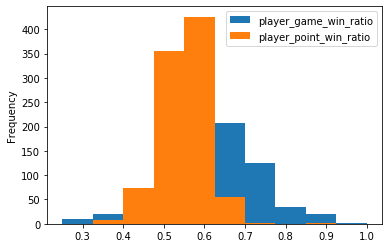

In [37]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Roger Federer', ['player_game_win_ratio', 'player_point_win_ratio']].plot.hist()

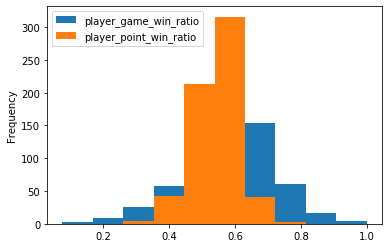

In [16]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Rafael Nadal', ['player_game_win_ratio', 'player_point_win_ratio']].plot.hist()

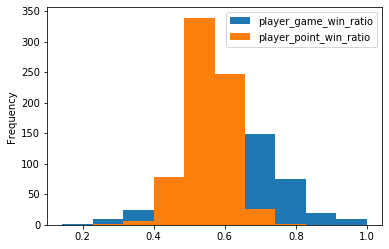

In [17]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Novak Djokovic', ['player_game_win_ratio', 'player_point_win_ratio']].plot.hist()

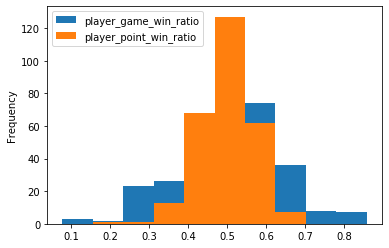

In [18]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Bernard Tomic', ['player_game_win_ratio', 'player_point_win_ratio']].plot.hist()

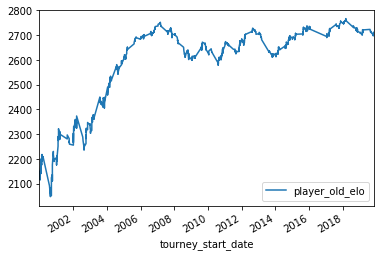

In [19]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Roger Federer', ['player_old_elo', 'tourney_start_date']].plot.line(x='tourney_start_date')

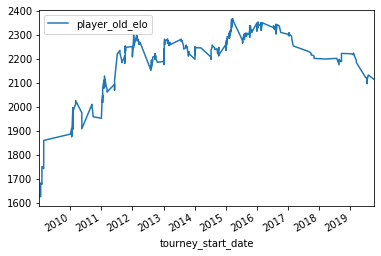

In [20]:
deuce_atp_long.loc[deuce_atp_long['player_name'] == 'Bernard Tomic', ['player_old_elo', 'tourney_start_date']].plot.line(x='tourney_start_date')

In [21]:
deuce_atp_long.columns

Index(['player_id', 'player_name', 'player_hand', 'player_ht', 'player_ioc',
       'player_age', 'player_rank', 'player_rank_points', 'player_ace',
       'player_df', 'player_svpt', 'player_1stIn', 'player_1stWon',
       'player_2ndWon', 'player_SvGms', 'player_bpSaved', 'player_bpFaced',
       'player_old_elo', 'player_total_games', 'player_RtGms', 'player_bp',
       'player_bpWon', 'player_2ndIn', 'player_rtpt', 'player_rtptWon',
       'player_svptWon', 'player_total_points', 'tourney_id', 'tourney_name',
       'surface', 'tourney_level', 'match_num', 'best_of', 'round', 'minutes',
       'retirement', 'tourney_start_date', 'year', 'match_id', 'total_points',
       'total_games', 'opponent_rank', 'won', 'player_serve_win_ratio',
       'player_return_win_ratio', 'player_bp_per_game',
       'player_bp_conversion_ratio', 'player_game_win_ratio',
       'player_point_win_ratio', 'player_clutch_factor', 'player_log_rank',
       'player_log_rank_points', 'player_win_weight',
   

In [22]:
# These are the tournaments we want to get the rolling average of features for, they will then be used for training
roll_dates = deuce_atp.loc[deuce_atp['tourney_level'].isin(['Grand Slams'])].groupby(['tourney_name', 'tourney_start_date'])\
.size().reset_index()[['tourney_name', 'tourney_start_date']]

# We also want to aggregate matches just before the 2020 AO
roll_dates.loc[-1] = ['Australian Open', pd.to_datetime('2020-01-20')]

last_cols = ['player_rank', 'player_log_rank', 'player_rank_points', 'player_log_rank_points', 'player_ht', 'player_old_elo']
rolling_cols = [
    'player_serve_win_ratio', 'player_return_win_ratio',
    'player_bp_per_game', 'player_bp_conversion_ratio',
    'player_game_win_ratio', 'player_point_win_ratio',
    'player_clutch_factor', 'player_win_weight',
    'player_game_win_ratio_weighted', 'player_point_win_ratio_weighted'
]

rolling_features = get_rolling_features(deuce_atp_long, roll_dates, rolling_cols, last_cols, 21  )

0 2000-01-17 00:00:00
1 2001-01-15 00:00:00
2 2002-01-14 00:00:00
3 2003-01-13 00:00:00
4 2004-01-19 00:00:00
5 2005-01-17 00:00:00
6 2006-01-16 00:00:00
7 2007-01-15 00:00:00
8 2008-01-14 00:00:00
9 2009-01-19 00:00:00
10 2010-01-18 00:00:00
11 2011-01-17 00:00:00
12 2012-01-16 00:00:00
13 2013-01-14 00:00:00
14 2014-01-13 00:00:00
15 2015-01-19 00:00:00
16 2016-01-18 00:00:00
17 2017-01-16 00:00:00
18 2018-01-15 00:00:00
19 2019-01-14 00:00:00
20 2000-08-28 00:00:00
21 2001-08-27 00:00:00
22 2002-08-26 00:00:00
23 2003-08-25 00:00:00
24 2004-08-30 00:00:00
25 2005-08-29 00:00:00
26 2006-08-28 00:00:00
27 2007-08-27 00:00:00
28 2008-08-25 00:00:00
29 2009-08-31 00:00:00
30 2010-08-30 00:00:00
31 2011-08-29 00:00:00
32 2012-08-27 00:00:00
33 2013-08-26 00:00:00
34 2014-08-25 00:00:00
35 2015-08-31 00:00:00
36 2016-08-29 00:00:00
37 2017-08-28 00:00:00
38 2018-08-27 00:00:00
39 2019-08-26 00:00:00
40 2020-01-20 00:00:00


In [23]:
deuce_atp_features = merge_data(deuce_atp, rolling_features)

In [24]:
# This is what the datafrmae should look like with the rolling features for p1 and p2 added
deuce_atp_features.loc[deuce_atp_features['tourney_level'] == 'Grand Slams',:]


,player_1,player_2,tourney_name,tourney_start_date,tourney_level,round,player_1_win,player_name_p1,player_serve_win_ratio_p1,player_return_win_ratio_p1,player_bp_per_game_p1,player_bp_conversion_ratio_p1,player_game_win_ratio_p1,player_point_win_ratio_p1,player_clutch_factor_p1,player_win_weight_p1,player_game_win_ratio_weighted_p1,player_point_win_ratio_weighted_p1,player_rank_p1,player_log_rank_p1,player_rank_points_p1,player_log_rank_points_p1,player_ht_p1,player_old_elo_p1,tournament_date_index_p1,player_name_p2,player_serve_win_ratio_p2,player_return_win_ratio_p2,player_bp_per_game_p2,player_bp_conversion_ratio_p2,player_game_win_ratio_p2,player_point_win_ratio_p2,player_clutch_factor_p2,player_win_weight_p2,player_game_win_ratio_weighted_p2,player_point_win_ratio_weighted_p2,player_rank_p2,player_log_rank_p2,player_rank_points_p2,player_log_rank_points_p2,player_ht_p2,player_old_elo_p2,tournament_date_index_p2
0,Andre Agassi,Mariano Puerta,Australian Open,2000-01-17,Grand Slams,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Mariano Puerta,0.603448,0.287879,0.400000,0.000000,0.350000,0.435484,-0.085484,0.000000,0.369420,0.459647,101.0,4.615121,355.0,5.872118,180.000000,1976.864196,2000-01-17
1,Sjeng Schalken,Galo Blanco,Australian Open,2000-01-17,Grand Slams,5,1,Sjeng Schalken,0.598205,0.439965,0.927790,0.329615,0.472162,0.509979,-0.037817,0.302716,0.437212,0.480205,44.0,3.784190,576.0,6.356108,193.000000,2113.308828,2000-01-17,Galo Blanco,0.657895,0.166667,0.000000,0.000000,0.454545,0.467742,-0.013196,0.000000,0.460033,0.473389,75.0,4.317488,542.0,6.295266,173.000000,2020.244766,2000-01-17
2,Mariano Zabaleta,Felix Mantilla,Australian Open,2000-01-17,Grand Slams,5,1,Mariano Zabaleta,0.559322,0.366972,0.466667,0.285714,0.448276,0.466960,-0.018684,0.000000,0.428122,0.445967,32.0,3.465736,972.0,6.879356,183.000000,2066.361541,2000-01-17,Felix Mantilla,0.490196,0.306150,0.300000,0.000000,0.255639,0.388664,-0.133025,0.000000,0.242943,0.366497,25.0,3.218876,1174.0,7.068172,180.000000,2129.053030,2000-01-17
3,Todd Woodbridge,Jan Siemerink,Australian Open,2000-01-17,Grand Slams,5,1,Todd Woodbridge,0.577586,0.378378,0.705882,0.416667,0.485714,0.480176,0.005538,0.000000,0.616230,0.609204,197.0,5.283204,143.0,4.962845,178.000000,1983.251857,2000-01-17,Jan Siemerink,0.539683,0.350877,0.333333,0.333333,0.333333,0.450000,-0.116667,0.000000,0.358218,0.483595,88.0,4.477337,388.0,5.961005,183.000000,2054.127883,2000-01-17
4,Andrew Ilie,Jeff Tarango,Australian Open,2000-01-17,Grand Slams,5,1,Andrew Ilie,0.528821,0.385436,0.507143,0.416667,0.360317,0.452724,-0.092406,0.278423,0.368503,0.463249,47.0,3.850148,729.0,6.591674,180.000000,2011.664594,2000-01-17,Jeff Tarango,0.640032,0.331765,0.272059,0.533333,0.466063,0.490099,-0.024036,0.000000,0.515612,0.542155,55.0,4.007333,562.0,6.331502,180.000000,2049.409778,2000-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25283,Gael Monfils,Matteo Berrettini,Us Open,2019-08-26,Grand Slams,2,0,Gael Monfils,0.652915,0.412680,0.780504,0.435735,0.579808,0.531081,0.044886,0.354634,0.516519,0.479862,33.0,3.496508,1265.0,7.142827,193.000000,2389.028739,2019-08-26,Matteo Berrettini,0.675736,0.338213,0.459646,0.449906,0.503492,0.501052,0.002441,0.253170,0.488218,0.486886,57.0,4.043051,909.0,6.812345,185.042357,2282.992091,2019-08-26
25284,Diego Sebastian Schwartzman,Rafael Nadal,Us Open,2019-08-26,Grand Slams,2,0,Diego Sebastian Schwartzman,0.628884,0.405449,0.788565,0.346311,0.539229,0.514962,0.024268,0.297041,0.499654,0.480444,17.0,2.833213,1880.0,7.539027,170.000000,2327.631648,2019-08-26,Rafael Nadal,0.692835,0.408589,0.690025,0.486126,0.618672,0.547757,0.065889,0.571058,0.563269,0.503788,1.0,0.000000,10040.0,9.214332,185.000000,2724.295491,2019-08-26
25285,Grigor Dimitrov,Daniil Medvedev,Us Open,2019-08-26,Grand Slams,3,0,Grigor Dimitrov,0.635253

In [25]:
diff_cols = [
    'player_rank', 'player_log_rank', 'player_rank_points', 'player_log_rank_points',
    'player_serve_win_ratio', 'player_return_win_ratio',
    'player_bp_per_game', 'player_bp_conversion_ratio',
    'player_game_win_ratio', 'player_point_win_ratio',
    'player_clutch_factor', 'player_win_weight', 'player_ht',
    'player_game_win_ratio_weighted', 'player_point_win_ratio_weighted', 'player_old_elo'
]

deuce_atp_final = get_player_difference(deuce_atp_features, diff_cols)

In [38]:
deuce_atp_final

,player_1,player_2,tourney_name,tourney_start_date,tourney_level,round,player_1_win,player_name_p1,tournament_date_index_p1,player_name_p2,tournament_date_index_p2,player_rank_diff,player_log_rank_diff,player_rank_points_diff,player_log_rank_points_diff,player_serve_win_ratio_diff,player_return_win_ratio_diff,player_bp_per_game_diff,player_bp_conversion_ratio_diff,player_game_win_ratio_diff,player_point_win_ratio_diff,player_clutch_factor_diff,player_win_weight_diff,player_ht_diff,player_game_win_ratio_weighted_diff,player_point_win_ratio_weighted_diff,player_old_elo_diff
0,Andre Agassi,Mariano Puerta,Australian Open,2000-01-17,Grand Slams,5,1,NaN,NaT,Mariano Puerta,2000-01-17,399.0,1.599488,-356.0,-6.872118,-1.603448,-1.287879,-1.400000,-1.000000,-1.350000,-1.435484,-0.914516,-1.000000,-181.0,-1.369420,-1.459647,-1977.864196
1,Sjeng Schalken,Galo Blanco,Australian Open,2000-01-17,Grand Slams,5,1,Sjeng Schalken,2000-01-17,Galo Blanco,2000-01-17,-31.0,-0.533298,34.0,0.060842,-0.059690,0.273298,0.927790,0.329615,0.017617,0.042237,-0.024621,0.302716,20.0,-0.022821,0.006817,93.064062
2,Mariano Zabaleta,Felix Mantilla,Australian Open,2000-01-17,Grand Slams,5,1,Mariano Zabaleta,2000-01-17,Felix Mantilla,2000-01-17,7.0,0.246860,-202.0,-0.188816,0.069126,0.060823,0.166667,0.285714,0.192637,0.078296,0.114340,0.000000,3.0,0.185179,0.079470,-62.691489
3,Todd Woodbridge,Jan Siemerink,Australian Open,2000-01-17,Grand Slams,5,1,Todd Woodbridge,2000-01-17,Jan Siemerink,2000-01-17,109.0,0.805867,-245.0,-0.998161,0.037904,0.027501,0.372549,0.083333,0.152381,0.030176,0.122205,0.000000,-5.0,0.258012,0.125609,-70.876026
4,Andrew Ilie,Jeff Tarango,Australian Open,2000-01-17,Grand Slams,5,1,Andrew Ilie,2000-01-17,Jeff Tarango,2000-01-17,-8.0,-0.157186,167.0,0.260172,-0.111210,0.053671,0.235084,-0.116667,-0.105746,-0.037375,-0.068370,0.278423,0.0,-0.147110,-0.078906,-37.745184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25385,Gael Monfils,Denis Shapovalov,Paris Masters,2019-10-28,Masters,2,0,NaN,NaT,NaN,NaT,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25386,Jo Wilfried Tsonga,Rafael Nadal,Paris Masters,2019-10-28,Masters,2,0,NaN,NaT,NaN,NaT,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25387,Grigor Dimitrov,Novak Djokovic,Paris Masters,2019-10-28,Masters,3,0,NaN,NaT,NaN,NaT,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25388,Rafael Nadal,Denis Shapovalov,Paris Masters,2019-10-28,Masters,3,0,NaN,NaT,NaN,NaT,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


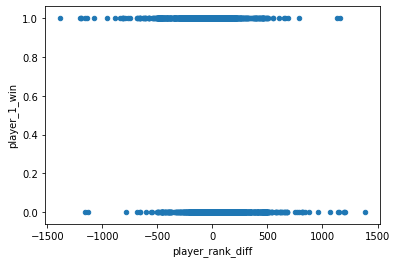

In [41]:
deuce_atp_final[['player_1_win', 'player_rank_diff']].plot.scatter(y='player_1_win', x='player_rank_diff')

In [42]:
deuce_atp_final[['player_1_win', 'player_rank_diff']].corr()

,player_1_win,player_rank_diff
player_1_win,1.000000,-0.195347
player_rank_diff,-0.195347,1.000000


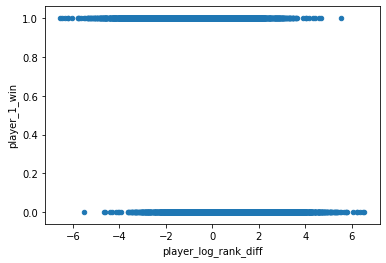

In [43]:
deuce_atp_final[['player_1_win', 'player_log_rank_diff']].plot.scatter(y='player_1_win', x='player_log_rank_diff')

In [44]:
deuce_atp_final[['player_1_win', 'player_log_rank_diff']].corr()

,player_1_win,player_log_rank_diff
player_1_win,1.000000,-0.299575
player_log_rank_diff,-0.299575,1.000000


In [26]:
deuce_atp_final.columns

Index(['player_1', 'player_2', 'tourney_name', 'tourney_start_date',
       'tourney_level', 'round', 'player_1_win', 'player_name_p1',
       'tournament_date_index_p1', 'player_name_p2',
       'tournament_date_index_p2', 'player_rank_diff', 'player_log_rank_diff',
       'player_rank_points_diff', 'player_log_rank_points_diff',
       'player_serve_win_ratio_diff', 'player_return_win_ratio_diff',
       'player_bp_per_game_diff', 'player_bp_conversion_ratio_diff',
       'player_game_win_ratio_diff', 'player_point_win_ratio_diff',
       'player_clutch_factor_diff', 'player_win_weight_diff', 'player_ht_diff',
       'player_game_win_ratio_weighted_diff',
       'player_point_win_ratio_weighted_diff', 'player_old_elo_diff'],
      dtype='object')

In [27]:
from xgboost import XGBClassifier
#Changing some settings to prevent xgboost from killing the kernal
#see https://stackoverflow.com/questions/51164771/python-xgboost-kernel-died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [28]:
ML_cols = [
       'player_1_win', 'player_rank_diff', 'player_log_rank_diff',
        'player_rank_points_diff', 'player_log_rank_points_diff',
       'player_serve_win_ratio_diff', 'player_return_win_ratio_diff',
       'player_bp_per_game_diff', 'player_bp_conversion_ratio_diff',
       'player_game_win_ratio_diff', 'player_point_win_ratio_diff',
       'player_clutch_factor_diff', 'player_win_weight_diff',
       'player_game_win_ratio_weighted_diff', 'player_ht_diff',
       'player_point_win_ratio_weighted_diff', 'round'
]

ML_cols_subset_0= [
    'player_log_rank_diff',
    'player_rank_diff',
    'player_serve_win_ratio_diff',
    'player_return_win_ratio_diff',
    'player_game_win_ratio_diff',
    'player_point_win_ratio_weighted_diff',
    'player_win_weight_diff',
    'player_1_win'
]

ML_cols_subset_1= [
    'player_log_rank_diff',
    'player_old_elo_diff',
    'player_rank_diff',
    'player_serve_win_ratio_diff',
    'player_return_win_ratio_diff',
    'player_game_win_ratio_diff',
    'player_point_win_ratio_weighted_diff',
    'player_win_weight_diff',
    'player_1_win'
]

model = XGBClassifier(
    objective = "binary:logistic"
)

model_a_priori = XGBClassifier(
    objective = "binary:logistic",
    n_estimators = 300,
    learning_rate = 0.02,
    max_depth = 6
)

In [29]:
np.mean(f_chain_val_scores(deuce_atp_final, model, ML_cols_subset_0, tournaments=['Australian Open']))

[0]	validation_0-logloss:0.678038
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[16]	validation_0-logloss:0.593953

[0]	validation_0-logloss:0.673567
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[23]	validation_0-logloss:0.578115

[0]	validation_0-logloss:0.674753
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[44]	validation_0-logloss:0.599771

[0]	validation_0-logloss:0.677789
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[15]	validation_0-logloss:0.619049

[0]	validation_0-logloss:0.674887
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[24]	validation_0-logloss:0.582882

[0]	validation_0-logloss:0.675528
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[22]	validation_0-logloss:0.600817

[0]	validation_0

0.5397221052631579

In [30]:
val_scores, test_scores = f_chain_val_test_scores(deuce_atp_final, model, ML_cols, tournaments=['Australian Open'])
print(np.mean(val_scores), np.mean(test_scores))

[0]	validation_0-logloss:0.675611
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[16]	validation_0-logloss:0.591407

[0]	validation_0-logloss:0.673508
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[34]	validation_0-logloss:0.574053

[0]	validation_0-logloss:0.675066
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[30]	validation_0-logloss:0.587728

[0]	validation_0-logloss:0.677317
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[13]	validation_0-logloss:0.624377

[0]	validation_0-logloss:0.672291
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[20]	validation_0-logloss:0.581026

[0]	validation_0-logloss:0.67647
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[14]	validation_0-logloss:0.603678

[0]	validation_0-

In [31]:
val_scores, test_scores = f_chain_val_test_scores(deuce_atp_final, model, ML_cols_subset_1, tournaments=['Australian Open'])
print(np.mean(val_scores), np.mean(test_scores))

[0]	validation_0-logloss:0.678038
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[18]	validation_0-logloss:0.591617

[0]	validation_0-logloss:0.673009
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[14]	validation_0-logloss:0.588652

[0]	validation_0-logloss:0.675322
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[14]	validation_0-logloss:0.599251

[0]	validation_0-logloss:0.677219
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[18]	validation_0-logloss:0.605227

[0]	validation_0-logloss:0.673277
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[25]	validation_0-logloss:0.575376

[0]	validation_0-logloss:0.675074
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[19]	validation_0-logloss:0.597858

[0]	validation_0

# Validation and Test Scores for Default Model

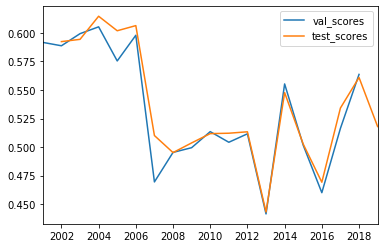

In [32]:
val_scores_series = pd.DataFrame({'val_scores':val_scores}, index = range(2001,2019))
test_scores_series = pd.DataFrame({'test_scores':test_scores}, index = range(2002, 2020))
scores_df = pd.concat([val_scores_series, test_scores_series], axis = 1)
scores_df.plot.line()

In [33]:
val_scores, test_scores = f_chain_val_test_scores(deuce_atp_final, model_a_priori, ML_cols_subset_1, tournaments=['Australian Open'])
print(np.mean(val_scores), np.mean(test_scores))

[0]	validation_0-logloss:0.690001
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[107]	validation_0-logloss:0.615465

[0]	validation_0-logloss:0.688814
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[66]	validation_0-logloss:0.608881

[0]	validation_0-logloss:0.689272
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[83]	validation_0-logloss:0.605269

[0]	validation_0-logloss:0.690503
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[69]	validation_0-logloss:0.620343

[0]	validation_0-logloss:0.688819
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[113]	validation_0-logloss:0.59005

[0]	validation_0-logloss:0.688566
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[60]	validation_0-logloss:0.599859

[0]	validation_

# Validation and Test Scores for a Badly Tuned Model

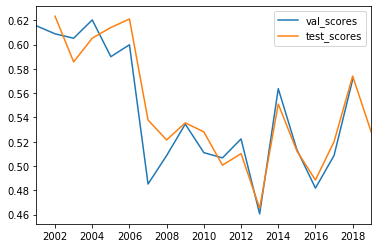

In [34]:
val_scores_series = pd.DataFrame({'val_scores':val_scores}, index = range(2001,2019))
test_scores_series = pd.DataFrame({'test_scores':test_scores}, index = range(2002, 2020))
scores_df = pd.concat([val_scores_series, test_scores_series], axis = 1)
scores_df.plot.line()

# Validation and Test Scores for US Open Only Model

In [35]:
val_scores, test_scores = f_chain_val_test_scores(deuce_atp_final, model, ML_cols_subset_1, tournaments=['US Open', 'Us Open'])
print(np.mean(val_scores), np.mean(test_scores))

[0]	validation_0-logloss:0.660277
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[24]	validation_0-logloss:0.492559

[0]	validation_0-logloss:0.661714
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[26]	validation_0-logloss:0.51756

[0]	validation_0-logloss:0.660439
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[22]	validation_0-logloss:0.503322

[0]	validation_0-logloss:0.675847
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[5]	validation_0-logloss:0.646523

[0]	validation_0-logloss:0.665343
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[49]	validation_0-logloss:0.518583

[0]	validation_0-logloss:0.669697
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[27]	validation_0-logloss:0.527552

[0]	validation_0-l

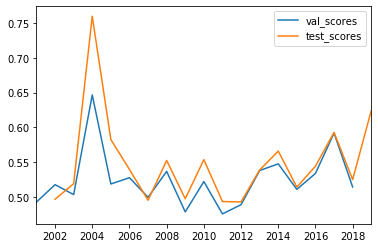

In [36]:
val_scores_series = pd.DataFrame({'val_scores':val_scores}, index = range(2001,2019))
test_scores_series = pd.DataFrame({'test_scores':test_scores}, index = range(2002, 2020))
scores_df = pd.concat([val_scores_series, test_scores_series], axis = 1)
scores_df.plot.line()

# Adversarial Validation

In [162]:
av_X = deuce_atp_final.copy()
av_y = np.where(av_X.tourney_name == 'Australian Open',1,0)
av_X = av_X.loc[:,['round', 'player_point_win_ratio_weighted_diff']]


X_train, X_test, y_train, y_test = train_test_split(av_X, av_y, test_size = 0.5, shuffle=True)

model = XGBClassifier(
    objective = "binary:logistic"
)

model.fit(
    X_train,
    y_train,
    eval_set = [(X_test, y_test)],
    eval_metric = 'auc'
)


[0]	validation_0-auc:0.878554
[1]	validation_0-auc:0.878688
[2]	validation_0-auc:0.879208
[3]	validation_0-auc:0.878962
[4]	validation_0-auc:0.878839
[5]	validation_0-auc:0.878814
[6]	validation_0-auc:0.878815
[7]	validation_0-auc:0.878815
[8]	validation_0-auc:0.878819
[9]	validation_0-auc:0.878806
[10]	validation_0-auc:0.878749
[11]	validation_0-auc:0.878925
[12]	validation_0-auc:0.879629
[13]	validation_0-auc:0.879361
[14]	validation_0-auc:0.879312
[15]	validation_0-auc:0.879393
[16]	validation_0-auc:0.87924
[17]	validation_0-auc:0.879358
[18]	validation_0-auc:0.879393
[19]	validation_0-auc:0.879351
[20]	validation_0-auc:0.879336
[21]	validation_0-auc:0.879359
[22]	validation_0-auc:0.879461
[23]	validation_0-auc:0.879325
[24]	validation_0-auc:0.8795
[25]	validation_0-auc:0.879562
[26]	validation_0-auc:0.879273
[27]	validation_0-auc:0.879445
[28]	validation_0-auc:0.879433
[29]	validation_0-auc:0.879357
[30]	validation_0-auc:0.879292
[31]	validation_0-auc:0.879338
[32]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [156]:
pd.Series(model.feature_importances_, index=ML_cols_subset_1)

player_log_rank_diff                    0.092063
player_old_elo_diff                     0.169387
player_rank_diff                        0.013943
player_serve_win_ratio_diff             0.013667
player_return_win_ratio_diff            0.028326
player_game_win_ratio_diff              0.628587
player_point_win_ratio_weighted_diff    0.022006
player_win_weight_diff                  0.017515
player_1_win                            0.014507
dtype: float32

# Some More Interesting Visualisations

In [79]:
train = deuce_atp_final.loc[deuce_atp_final.tourney_name == 'Australian Open', ML_cols_subset_1]
y_train = train['player_1_win']
X_train = train.drop('player_1_win', axis=1)

In [80]:
model = XGBClassifier(
    objective = "binary:logistic"
)

model.fit(X_train, y_train)

preds = model.predict_proba(X_train)

preds[:,1]

array([0.4282987 , 0.7678532 , 0.54096353, ..., 0.07054648, 0.06771182,
       0.4156641 ], dtype=float32)

In [81]:
train_preds = X_train.copy()
train_preds.loc[:,'player_1_win_pred'] = preds[:,1]

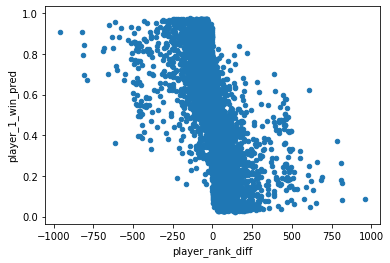

In [82]:
train_preds.plot.scatter(x='player_rank_diff', y='player_1_win_pred')

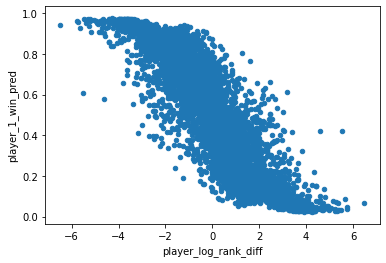

In [83]:
train_preds.plot.scatter(x='player_log_rank_diff', y='player_1_win_pred')

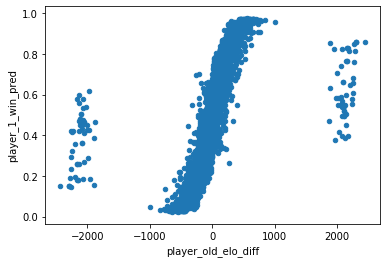

In [84]:
train_preds.plot.scatter(x='player_old_elo_diff', y='player_1_win_pred')

# Predictions

In [114]:
preds = pd.read_csv('Data/test_submission_expost.csv')
preds.groupby('player_1')['player_1_win_probability'].agg('mean').sort_values(ascending=False).head(100)

player_1
rafael nadal                    0.883121
novak djokovic                  0.879700
roger federer                   0.877201
dominic thiem                   0.826868
daniil medvedev                 0.780728
matteo berrettini               0.774844
kevin anderson                  0.759034
stefanos tsitsipas              0.754115
alexander zverev                0.748855
gael monfils                    0.741878
diego sebastian schwartzman     0.732697
stan wawrinka                   0.726816
john isner                      0.717387
roberto bautista agut           0.712696
david goffin                    0.711760
jo wilfried tsonga              0.708516
nick kyrgios                    0.707493
milos raonic                    0.689394
andrey rublev                   0.688020
felix auger aliassime           0.685827
grigor dimitrov                 0.684093
kyle edmund                     0.671568
marin cilic                     0.660699
denis shapovalov                0.656660
filip k

In [115]:
preds

,Unnamed: 0,player_1,player_2,player_1_win_probability
0,0,rafael nadal,hugo dellien,0.908778
1,1,rafael nadal,federico delbonis,0.908778
2,2,rafael nadal,joao sousa,0.908778
3,3,rafael nadal,christopher eubanks,0.894184
4,4,rafael nadal,peter gojowczyk,0.908778
...,...,...,...,...
16251,16251,novak djokovic,yoshihito nishioka,0.908778
16252,16252,novak djokovic,laslo djere,0.903594
16253,16253,novak djokovic,tatsuma ito,0.909225
16254,16254,novak djokovic,prajnesh gunneswaran,0.908778
